In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-11-28 15:39:19.901174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 15:39:20.088305: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so
I1128 15:39:20.192160021  379716 ev_epoll1_linux.cc:121]     grpc epoll fd: 70
D1128 15:39:20.192185009  379716 ev_posix.cc:141]            Using polling engine: epoll1
D1128 15:39:20.192219141  379716 lb_policy_registry.cc:43]   registering LB policy factory for "grpclb"
D1128 15:39:20.192228514  379716 lb_policy_registry.cc:43]   registering LB policy factory for "rls_experimental"
D1128 15:39:20.192237512  379716 lb_policy_registry.cc:43]   registering LB policy factory for "priority_experimental"
D1128 15:39:20

In [3]:
tf.config.list_logical_devices('TPU')

2022-11-28 15:39:22.162383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 15:39:25.924566: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x8402750 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-11-28 15:39:25.924598: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): TPU, 2a886c8
2022-11-28 15:39:25.924606: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): TPU, 2a886c8
2022-11-28 15:39:25.924612: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): TPU, 2a886c8
2022-11-28 15:39:25.924618: I tensorflow/compiler/xla/service/service.cc:181]   

[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

r device (6): TPU, 2a886c8
2022-11-28 15:39:25.924641: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (7): TPU, 2a886c8


In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [5]:
batch_size = 64
img_height = 240
img_width = 240
data_dir = os.path.join('data','UPENN-GBM','slice_classification_common_stratify','train')


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49725 files belonging to 5 classes.
Using 39780 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49725 files belonging to 5 classes.
Using 9945 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['background', 'background_edema', 'background_edema_contrast', 'background_tumour_edema', 'background_tumour_edema_contrast']


In [9]:
 # Calculate class weights ofr weighting accuracy
ds_classes = []
for _, batch_classes in train_ds:
    ds_classes.append(batch_classes.numpy())

ds_classes = np.concatenate(ds_classes)

class_weight = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(ds_classes),
    y=ds_classes
)

class_weight = dict(zip(np.unique(ds_classes), class_weight))


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./(2**8-1))

In [12]:
num_classes = len(class_names)

In [13]:
margin = 8
scaled_height = img_height - 2*margin
scaled_width = img_width - 2*margin

In [14]:
# Build layers for model


In [15]:

with strategy.scope():
    crop_layer = tf.keras.layers.Cropping2D(margin)
    #rescale_initial = tf.keras.layers.Rescaling(1./127.5, offset=-1)
    rescale_initial = tf.keras.layers.Rescaling(1./255)
    conv_4to3_channel = tf.keras.layers.Conv2D(3,1,padding='same', activation='tanh')
    trained_base_model = tf.keras.applications.MobileNetV2(
        input_shape=(scaled_width,scaled_height,3),
        include_top=False,
        weights='imagenet'
    )
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(num_classes)

    trained_base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(img_width, img_height, 4))
    x = crop_layer(inputs)
    x = rescale_initial(x)
    x = conv_4to3_channel(x)
    x = trained_base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
   
    earlystopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
         patience=5,
         min_delta=0.001)
    
    model_fixed_base = tf.keras.Model(inputs, outputs)
    model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
    )

2022-11-28 15:39:48.225042: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-28 15:39:48.289332: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [16]:
model_fixed_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 4)]     0         
                                                                 
 cropping2d (Cropping2D)     (None, 224, 224, 4)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 4)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       15        
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [17]:
small_model_epochs=80
history_model_fixed_base = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=small_model_epochs,
  class_weight=class_weight,
  callbacks=[earlystopping],
)

2022-11-28 15:40:05.292703: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39780
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 1/80


2022-11-28 15:40:11.155203: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:7508030043732270841
2022-11-28 15:40:11.426415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-28 15:40:11.715237: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-28 15:40:16.035224: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(383136098441396369), session_name()


  2/622 [..............................] - ETA: 36s - loss: 2.2105 - accuracy: 0.1406    

2022-11-28 15:40:22.053033: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 383136098441396369 with session name  took 6.017697657s and succeeded
2022-11-28 15:40:22.077834: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(383136098441396369), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_7508030043732270841", property.function_library_fingerprint = 14719711814958832020, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,4,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-28 15:40:22.077889: I tensorflow/c

 36/622 [>.............................] - ETA: 20s - loss: 1.9336 - accuracy: 0.1957

2022-11-28 15:40:23.392028: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(4929269968073737045), session_name()


 40/622 [>.............................] - ETA: 1:54 - loss: 1.9159 - accuracy: 0.1983

2022-11-28 15:40:29.629152: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 4929269968073737045 with session name  took 6.237047422s and succeeded
2022-11-28 15:40:29.652803: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(4929269968073737045), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_7508030043732270841", property.function_library_fingerprint = 14719711814958832020, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "5,240,240,4,;5,;5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-28 15:40:29.652859: I tensorflow

622/622 [==============================] - ETA: 0s - loss: 1.5395 - accuracy: 0.3806

2022-11-28 15:40:47.931889: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9945
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-11-28 

622/622 [==============================] - 56s 65ms/step - loss: 1.5395 - accuracy: 0.3806 - val_loss: 1.2877 - val_accuracy: 0.4748


2022-11-28 15:41:02.469380: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 16409134106131111377 with session name  took 3.608981684s and succeeded
2022-11-28 15:41:02.482035: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(16409134106131111377), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_15450537635097717211", property.function_library_fingerprint = 10383662355163757858, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "4,240,240,4,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-28 15:41:02.482081: I tensorflow/

Epoch 2/80
622/622 [==============================] - 24s 39ms/step - loss: 1.3886 - accuracy: 0.4456 - val_loss: 1.3067 - val_accuracy: 0.4333
Epoch 3/80
622/622 [==============================] - 24s 38ms/step - loss: 1.3397 - accuracy: 0.4628 - val_loss: 1.1411 - val_accuracy: 0.5574
Epoch 4/80
622/622 [==============================] - 22s 35ms/step - loss: 1.2886 - accuracy: 0.4891 - val_loss: 1.1005 - val_accuracy: 0.5822
Epoch 5/80
622/622 [==============================] - 23s 37ms/step - loss: 1.2554 - accuracy: 0.5033 - val_loss: 1.1175 - val_accuracy: 0.5771
Epoch 6/80
622/622 [==============================] - 22s 36ms/step - loss: 1.2274 - accuracy: 0.5216 - val_loss: 1.0879 - val_accuracy: 0.5923
Epoch 7/80
622/622 [==============================] - 23s 38ms/step - loss: 1.1941 - accuracy: 0.5283 - val_loss: 1.0815 - val_accuracy: 0.5877
Epoch 8/80
622/622 [==============================] - 22s 35ms/step - loss: 1.1769 - accuracy: 0.5395 - val_loss: 1.0773 - val_accuracy:

In [18]:
layer_outputs = [layer.output for layer in model_fixed_base.layers[:4]]
vis_model = tf.keras.models.Model(
    inputs=model_fixed_base.input, 
    outputs=layer_outputs
)

In [19]:
#((activations[-1][1,:,:,:]+1)*127.5).astype('uint8')

1/1 [==============================] - 0s 26ms/step


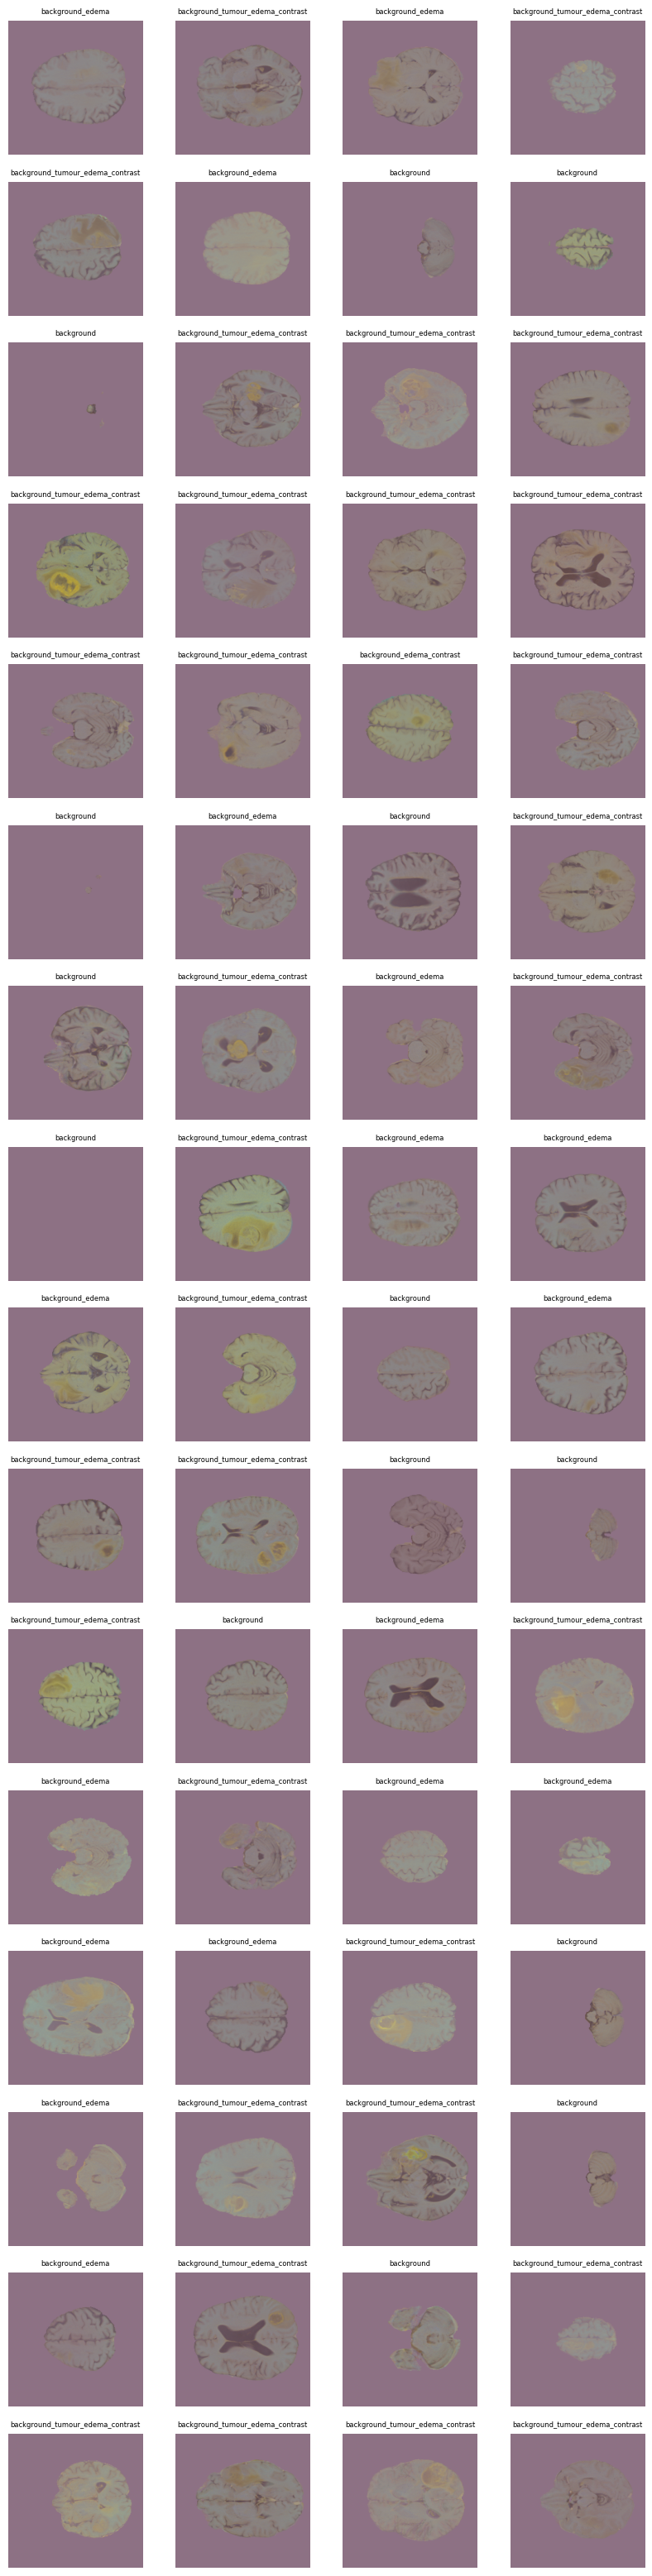

In [20]:
plt.figure(figsize=(10, 40))
batch = train_ds.take(1)
#activations = vis_model.predict(batch)
for images, labels in batch:
  for i in range(64):
    image = np.expand_dims(images[i], axis=0)
    activation = vis_model.predict(image)
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(((activation[-1][0,:,:,:]+1)*127.5).astype('uint8'))
    plt.title(class_names[labels[i]], fontsize=6)
    plt.axis("off")

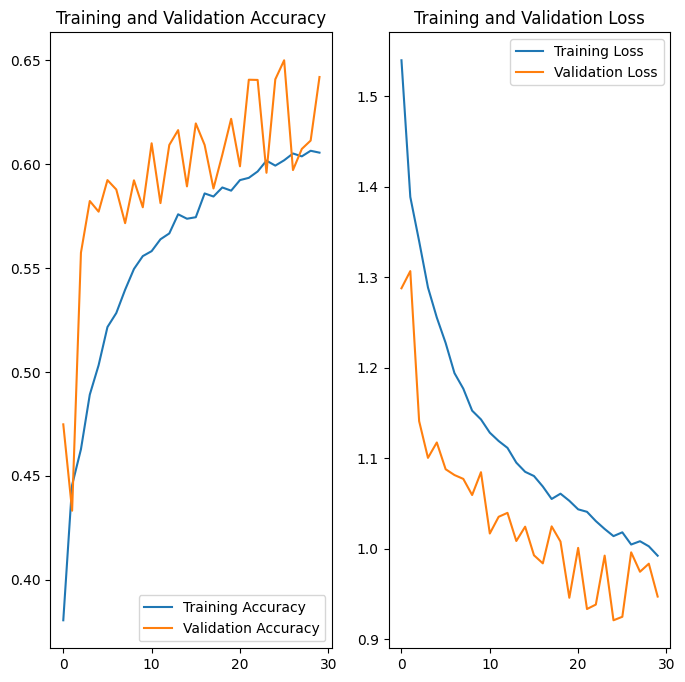

In [21]:
acc = history_model_fixed_base.history['accuracy']
val_acc = history_model_fixed_base.history['val_accuracy']

loss = history_model_fixed_base.history['loss']
val_loss = history_model_fixed_base.history['val_loss']

epochs_range = range(small_model_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
trained_base_model.trainable = True

In [23]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in trained_base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [24]:
with strategy.scope():
  model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
  )

In [25]:
fine_tuning_epochs=100
total_epochs = small_model_epochs + fine_tuning_epochs
history_fine_tuning = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epochs,
  initial_epoch=history_model_fixed_base.epoch[-1],
  class_weight=class_weight,
  callbacks=[earlystopping],
)

2022-11-28 15:52:22.126816: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39780
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 30/180


2022-11-28 15:52:30.763693: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:1399955724167508500
2022-11-28 15:52:31.273685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-28 15:52:31.666967: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-28 15:52:32.352699: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(4372114726580298631), session_name()


  2/622 [..............................] - ETA: 33s - loss: 1.3334 - accuracy: 0.6719    

2022-11-28 15:52:40.938677: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 4372114726580298631 with session name  took 8.585901127s and succeeded
2022-11-28 15:52:40.974153: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(4372114726580298631), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_1399955724167508500", property.function_library_fingerprint = 9425000604112663439, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,4,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-28 15:52:40.974211: I tensorflow/

477/622 [======================>.......] - ETA: 4s - loss: 1.0391 - accuracy: 0.5955

2022-11-28 15:52:56.699836: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(2253302594167214053), session_name()


480/622 [======================>.......] - ETA: 7s - loss: 1.0402 - accuracy: 0.5959

2022-11-28 15:53:04.871281: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 2253302594167214053 with session name  took 8.171375165s and succeeded
2022-11-28 15:53:04.906330: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(2253302594167214053), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_1399955724167508500", property.function_library_fingerprint = 9425000604112663439, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "5,240,240,4,;5,;5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-28 15:53:04.906384: I tensorflow/

622/622 [==============================] - ETA: 0s - loss: 1.0227 - accuracy: 0.6013

2022-11-28 15:53:09.617054: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9945
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-11-28 

622/622 [==============================] - 53s 57ms/step - loss: 1.0227 - accuracy: 0.6013 - val_loss: 0.8234 - val_accuracy: 0.6913
Epoch 31/180
622/622 [==============================] - 24s 39ms/step - loss: 0.9200 - accuracy: 0.6325 - val_loss: 0.8841 - val_accuracy: 0.6228
Epoch 32/180
622/622 [==============================] - 24s 39ms/step - loss: 0.8382 - accuracy: 0.6582 - val_loss: 0.8427 - val_accuracy: 0.6508
Epoch 33/180
622/622 [==============================] - 24s 38ms/step - loss: 0.7841 - accuracy: 0.6771 - val_loss: 0.8356 - val_accuracy: 0.6804
Epoch 34/180
622/622 [==============================] - 24s 39ms/step - loss: 0.7265 - accuracy: 0.6919 - val_loss: 0.7551 - val_accuracy: 0.7118
Epoch 35/180
622/622 [==============================] - 24s 38ms/step - loss: 0.6751 - accuracy: 0.7088 - val_loss: 0.6573 - val_accuracy: 0.7401
Epoch 36/180
622/622 [==============================] - 24s 39ms/step - loss: 0.6320 - accuracy: 0.7181 - val_loss: 0.6600 - val_accuracy

In [26]:
layer_outputs = [layer.output for layer in model_fixed_base.layers[:4]]
vis_model = tf.keras.models.Model(
    inputs=model_fixed_base.input, 
    outputs=layer_outputs
)

1/1 [==============================] - 0s 26ms/step


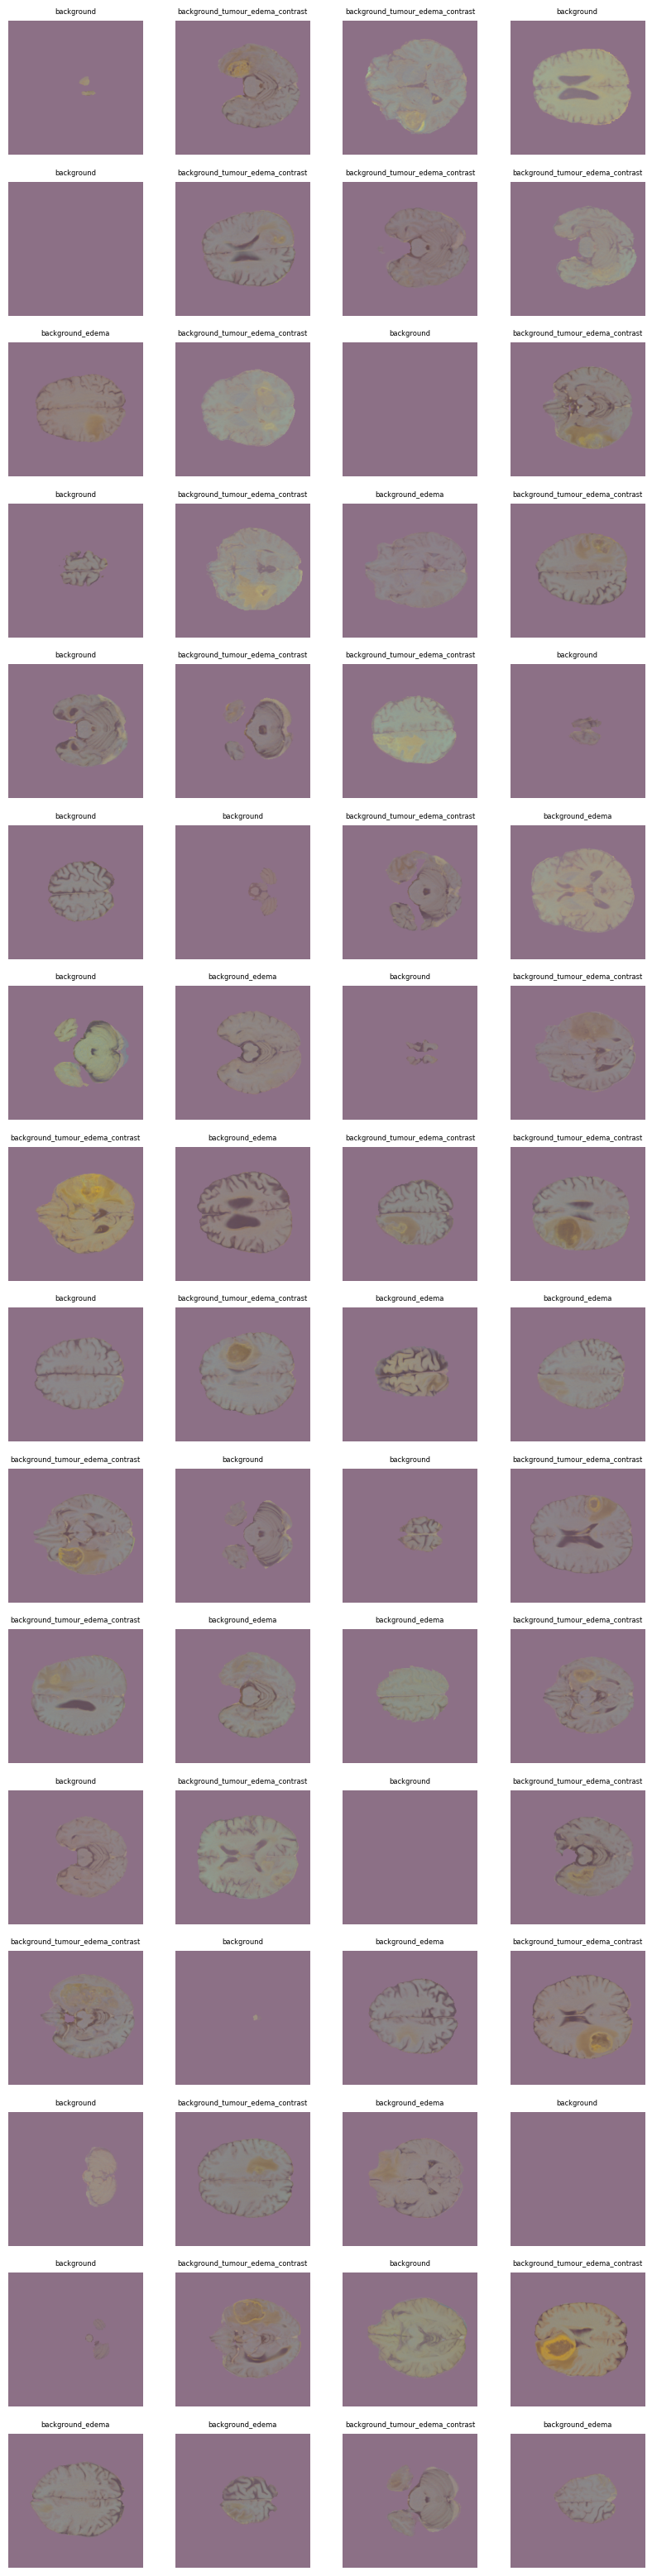

In [27]:
plt.figure(figsize=(10, 40))
for images, labels in batch:
  for i in range(64):
    image = np.expand_dims(images[i], axis=0)
    activation = vis_model.predict(image)
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(((activation[-1][0,:,:,:]+1)*127.5).astype('uint8'))
    plt.title(class_names[labels[i]], fontsize=6)
    plt.axis("off")

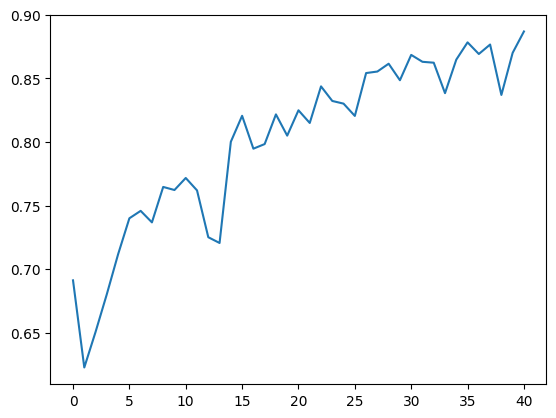

In [28]:
acc_fine = history_fine_tuning.history['val_accuracy']
loss_fine = history_fine_tuning.history['val_loss']
plt.plot(acc_fine)

In [29]:
trained_base_model.trainable = True
for layer in trained_base_model.layers:
    print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [30]:
with strategy.scope():
  model_fixed_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
  )
  

In [31]:
full_relax_epochs=100
total_epochs += full_relax_epochs
history_fine_tuning = model_fixed_base.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epochs,
  initial_epoch=history_fine_tuning.epoch[-1],
  class_weight=class_weight,
  callbacks=[earlystopping],
)

2022-11-28 16:09:50.209683: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 39780
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 70/280


2022-11-28 16:10:05.358525: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:10008876701896965541
2022-11-28 16:10:06.191543: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-28 16:10:06.754435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-11-28 16:10:07.814623: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(898528621228758066), session_name()


  2/622 [..............................] - ETA: 37s - loss: 0.0924 - accuracy: 0.9531    

2022-11-28 16:10:21.135282: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 898528621228758066 with session name  took 13.320577542s and succeeded
2022-11-28 16:10:21.177514: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(898528621228758066), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_10008876701896965541", property.function_library_fingerprint = 2895637832302738348, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "8,240,240,4,;8,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-28 16:10:21.177599: I tensorflow/

 61/622 [=>............................] - ETA: 24s - loss: 0.0937 - accuracy: 0.9549

2022-11-28 16:10:23.936291: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(8470252402680450856), session_name()


 65/622 [==>...........................] - ETA: 2:28 - loss: 0.0922 - accuracy: 0.9557

2022-11-28 16:10:38.147408: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 8470252402680450856 with session name  took 14.211039133s and succeeded
2022-11-28 16:10:38.189609: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(8470252402680450856), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_10008876701896965541", property.function_library_fingerprint = 2895637832302738348, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "5,240,240,4,;5,;5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-11-28 16:10:38.189664: I tensorflo

621/622 [============================>.] - ETA: 0s - loss: 0.1207 - accuracy: 0.9443

2022-11-28 16:11:01.875691: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 9945
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:7"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-11-28 

622/622 [==============================] - 78s 77ms/step - loss: 0.1208 - accuracy: 0.9442 - val_loss: 0.5550 - val_accuracy: 0.7986
Epoch 71/280
622/622 [==============================] - 31s 50ms/step - loss: 0.0894 - accuracy: 0.9576 - val_loss: 0.3765 - val_accuracy: 0.8910
Epoch 72/280
622/622 [==============================] - 30s 49ms/step - loss: 0.0746 - accuracy: 0.9664 - val_loss: 0.4327 - val_accuracy: 0.8677
Epoch 73/280
622/622 [==============================] - 31s 49ms/step - loss: 0.0720 - accuracy: 0.9658 - val_loss: 0.3860 - val_accuracy: 0.8844
Epoch 74/280
622/622 [==============================] - 31s 49ms/step - loss: 0.0866 - accuracy: 0.9608 - val_loss: 0.3925 - val_accuracy: 0.8807
Epoch 75/280
622/622 [==============================] - 30s 49ms/step - loss: 0.0545 - accuracy: 0.9760 - val_loss: 0.3808 - val_accuracy: 0.8901
Epoch 76/280
622/622 [==============================] - 31s 49ms/step - loss: 0.1391 - accuracy: 0.9454 - val_loss: 0.3628 - val_accuracy

1/1 [==============================] - 0s 34ms/step


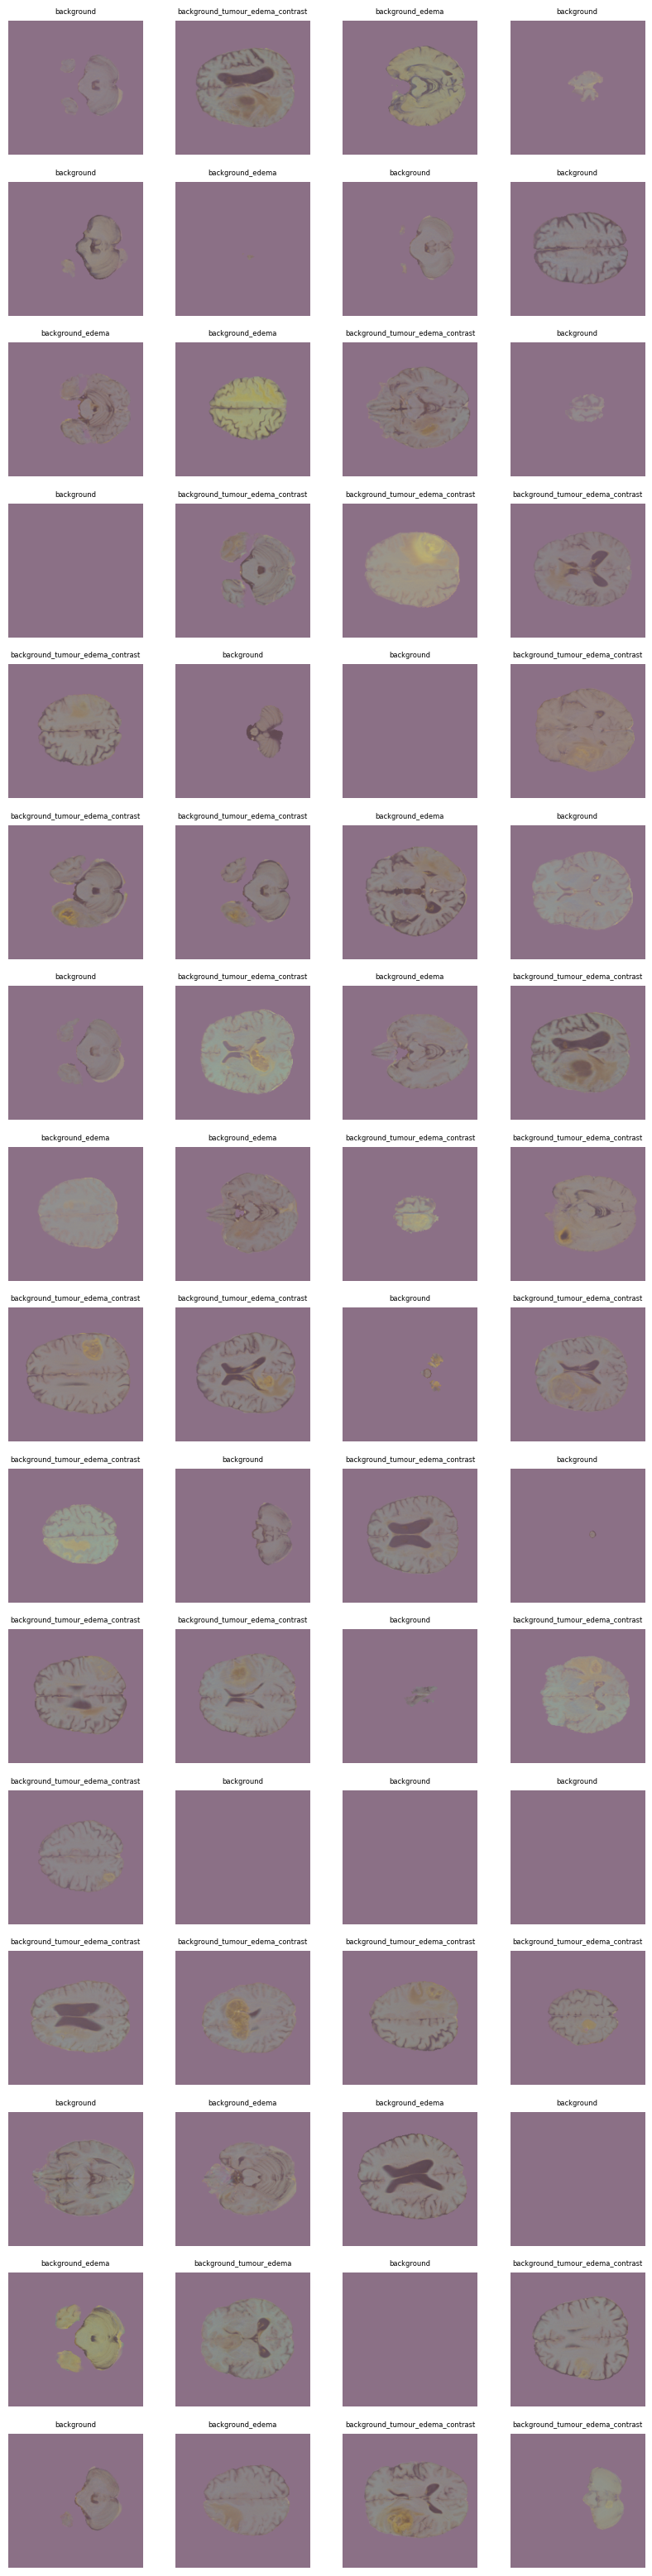

In [32]:
layer_outputs = [layer.output for layer in model_fixed_base.layers[:4]]
vis_model = tf.keras.models.Model(
    inputs=model_fixed_base.input, 
    outputs=layer_outputs
)

plt.figure(figsize=(10, 40))
#batch = train_ds.take(1)
#activations = vis_model.predict(batch)
for images, labels in batch:
  for i in range(64):
    image = np.expand_dims(images[i], axis=0)
    activation = vis_model.predict(image)
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(((activation[-1][0,:,:,:]+1)*127.5).astype('uint8'))
    plt.title(class_names[labels[i]], fontsize=6)
    plt.axis("off")

In [33]:
for ch in range(3):

    print(
        (((activation[-1][:,:,:,ch]+1)*127.5).astype('uint8')).min(), 
        (((activation[-1][:,:,:,ch]+1)*127.5).astype('uint8')).max(), 
    )

117 161
105 153
109 139
